# Ground Projection with KITTI

Going to load some [raw data from KITTI](http://www.cvlibs.net/datasets/kitti/raw_data.php) and project it to a pseudo ground plane...

Rough schematic of vehicle configuration provided here:

<img src='http://www.cvlibs.net/datasets/kitti/images/setup_top_view.png' width='680' align='left'>

In [1]:
from collections import namedtuple

import cv2

import numpy as np
import matplotlib.pyplot as plt
import transforms3d

from utils import data, geometry

In [2]:
calibration, df = data.get_kitti_data(drive='2011_09_26', sequence=1)
df.head()

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,pn,pu,timestamp_00,image_00,timestamp_01,image_01,timestamp_02,image_02,timestamp_03,image_03
2011-09-26 13:02:25.964389445,49.015004,8.434297,116.430328,0.035752,0.009030,-2.608707,-6.811441,-11.275642,13.172717,-0.124753,...,0.000000,0.000000,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...
2011-09-26 13:02:26.074347616,49.014997,8.434280,116.432274,0.036453,0.008009,-2.611005,-6.769916,-11.250719,13.129880,-0.129612,...,-0.742393,0.001945,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...
2011-09-26 13:02:26.174598199,49.014991,8.434265,116.435295,0.035908,0.006461,-2.613314,-6.731519,-11.221558,13.084994,-0.140397,...,-1.414094,0.004966,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...
2011-09-26 13:02:26.274369566,49.014985,8.434249,116.440720,0.035565,0.005031,-2.615904,-6.684933,-11.198743,13.041455,-0.144497,...,-2.079089,0.010390,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...
2011-09-26 13:02:26.384417986,49.014979,8.434233,116.447853,0.034299,0.006470,-2.618804,-6.634209,-11.175295,12.995313,-0.148616,...,-2.806690,0.017522,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...,1.317042e+09,data-cache/2011_09_26/2011_09_26_drive_0001_sy...


## Projecting a single frame

We'd like to project images from camera `00` onto a 'pseudo gound-plane'. This pseudo ground plane will be a locally level plane (based on the orientation estimated by the IMU).

**Define frames used below**

In [3]:
# Break out some calibration transforms to make this easier on ourselves.
transform_VI = geometry.SE3(R=calibration.R_VI, p=calibration.p_VI_V)
transform_CV = geometry.SE3(R=calibration.R_CV, p=calibration.p_CV_C)

In [4]:
# Load data from first dataframe.
d = df.iloc[0]

In [5]:
# First, let's visualize the ground region of interest in the image frame.

# Create some pseudo ground plane in front of the vehicle (IMU...). Let's assume 
# the camera is maybe ~1m above the ground.
transform_GI = geometry.SE3(R=geometry.rot_from_rph_rad(d.roll, d.pitch, 0.0),
                            p=-np.array([25.0, 0.0, d.pu - 1.0]))  # Note: we're writing p_IG_G

# Compute transform between camera (C) and ground (G) frames.
transform_GC = transform_GI @ transform_VI.inverse() @ transform_CV.inverse()
transform_CG = transform_GC.inverse()

# Define the ground region of interest by a few corner points.
pts_Gi_G = [np.array([-5, -12.5, 0]),
            np.array([-5,  12.5, 0]),
            np.array([ 5,  12.5, 0]),
            np.array([ 5, -12.5, 0])]

def _project(K, p):
    u = K @ p
    u /= u[2]
    return u[:2]

u_Ci_C2d = [_project(calibration.P_rect_00[:3, :3], transform_CG * p_Gi_G)
                for p_Gi_G in pts_Gi_G]
u_Ci_C2d = np.array(u_Ci_C2d + [u_Ci_C2d[0]])

im = cv2.imread(d.image_00)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [6]:
# Let's plot this same region as viewed from some virtual camera orthogonal to the ground plane.
# We'll define the frame of our virtual camera (M) wrt the ground frame (G).
transform_GM = geometry.SE3(R=np.array([[-1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, -1.0]]),
                            p=np.array([0.0, 0.0, 1.0]))
transform_MC = transform_GM.inverse() @ transform_GC

# Set up our virual camera.
m_per_px = 0.2
w_m, h_m = 30, 30
w_px, h_px = int(w_m / m_per_px), int(h_m / m_per_px)
K = np.array([[transform_GM.p[2] / m_per_px, 0.0,                          w_px / 2.0],
              [0.0,                          transform_GM.p[2] / m_per_px, h_px / 2.0],
              [0.0,                          0.0,                          1.0]])

# To compute the homography from camera image plane to virtual image plane we'll need to
# compute some plane parameters.
R_CG = transform_GC.R.T
unit_Gz_G = np.array([0.0, 0.0, 1.0])
unit_Gz_C = R_CG @ unit_Gz_G
dz = unit_Gz_C.dot(R_CG @ transform_GC.p)

H = K @ (transform_MC.R - np.outer(transform_MC.p, unit_Gz_C) / dz) @ \
    np.linalg.inv(calibration.P_rect_00[:3, :3])
H /= H[2, 2]

imw = cv2.warpPerspective(im, H, dsize=(w_px, h_px))

# Project corner points into M.
transform_MG = transform_GM.inverse()
u_Mi_M2d = [_project(K, transform_MG * p_Gi_G) for p_Gi_G in pts_Gi_G]
u_Mi_M2d = np.array(u_Mi_M2d + [u_Mi_M2d[0]])

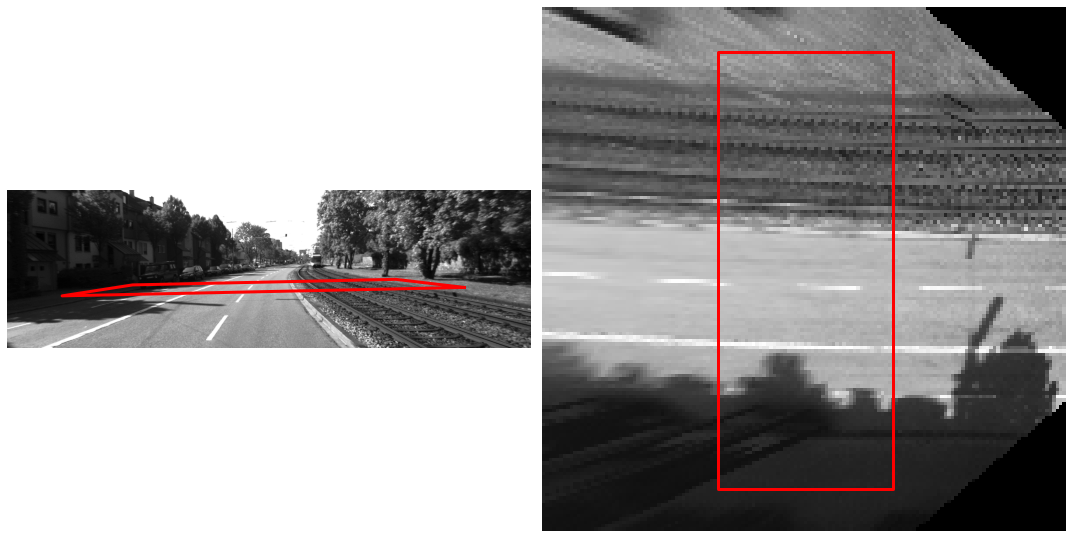

In [7]:
fig = plt.figure(figsize=(15, 11))

ax1 = fig.add_subplot(121)
ax1.imshow(im, cmap='Greys_r')
ax1.plot(u_Ci_C2d[:, 0], u_Ci_C2d[:, 1], 'r', lw=3)
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(imw, cmap='Greys_r')
ax2.plot(u_Mi_M2d[:, 0], u_Mi_M2d[:, 1], 'r', lw=3)
ax2.axis('off')

fig.tight_layout()

## Projecting multiple frames

Using the vehicle state estimate, we can aggregate multiple frames into a common frame.

**Define frames used below.**

In [8]:
class GroundProjection:
    def __init__(self, *, transform_NG, m_per_px, image):
        self.transform_NG = transform_NG
        self.m_per_px = m_per_px
        self.im = image
    
    @staticmethod
    def create(*, transform_NG, width_m, height_m, m_per_px):
        """Create GroundProjection object ...
        
        Parameters
        ----------
        transform_NG : transform between ENU (N) and center of ground projection plane.
        
        width_m : width of image plane in meters
        height_m : height of image plane in meters
        m_per_px : meters per pixel
        """
        g = GroundProjection(transform_NG=transform_NG,
                             m_per_px=m_per_px,
                             image=np.zeros((int(width_m / m_per_px), int(height_m / m_per_px))))
        return g
    
    @staticmethod
    def create_test(*, transform_NG, width_m, height_m, m_per_px):
        """XXX
        """
        # Create base ground plane.
        g = GroundProjection.create(
            transform_NG=transform_NG, width_m=width_m, height_m=height_m, m_per_px=m_per_px)
        
        # Project image onto ground plane image.
        g.im[:, :] = 1
        
        return g
    
    def _center(self):
        """Returns pixel coordinates of 'camera center'."""
        return 0.5 * np.array([self.im.shape[1], self.im.shape[0]])
    
    def add(self, g):
        """Add another ground projection.
        
        XXX orthographic projection...
        
        Parameters
        ----------
        g : other GroundProjection object
        """
        # Transform between ENU (N) and mosaic frame (M).
        transform_GM = geometry.SE3(R=np.array([[1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]]),
                                    p=np.zeros(3))
        transform_NM = self.transform_NG @ transform_GM
        
        # Transform between ENU (N) and other mosaic frame (Mo).
        transform_GMo = geometry.SE3(R=np.array([[-1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, -1.0]]),
                                     p=np.zeros(3))
        transform_NMo = g.transform_NG @ transform_GMo
        
        # Transform between mosaic frames.
        # Note: Rotation should be about the z-axis only.
        transform_MMo = transform_NM.inverse() @ transform_NMo
        
        # Construct some similarity transform--2x3 affine matrix
        R = transform_MMo.R[:2, :2]
        p = transform_MMo.p[:2]
    
        M = np.zeros((2, 3))
        M[:2, :2] = -(g.m_per_px / self.m_per_px) * R
        M[:2, 2] = (1.0 / self.m_per_px) * (g.m_per_px * R @ g._center() + p) + self._center()
        im = cv2.warpAffine(g.im, M, dsize=(self.im.shape[1], self.im.shape[0]))
        self.im += im

In [9]:
# At each frame, project corners from ROI into some world mosaic frame.
frames = []
for i, d in df.iterrows():
    # Transform between IMU (I) and ENU (N) frame.
    transform_NI = geometry.SE3(R=geometry.rot_from_rph_rad(d.roll, d.pitch, d.yaw),
                                p=np.array([d.pe, d.pn, d.pu]))
    
    # Let's define some ground frame (G) as a frame that is locally-level, yaw aligned with the IMU,
    # and has origin a fixed distance in front of the IMU on the ground.
    transform_GI = geometry.SE3(R=geometry.rot_from_rph_rad(d.roll, d.pitch, 0.0),
                                p=-np.array([25.0, 0.0, d.pu - 1.0]))
 
    # XXX
    frames.append(
        GroundProjection.create_test(
            transform_NG=transform_NI @ transform_GI.inverse(),
            width_m=25, height_m=10, m_per_px=0.1))  # XXX width/height flipped?

p_NI_N = np.vstack([df['pe'], df['pn'], df['pu']])
mosaic = GroundProjection.create(
    transform_NG=geometry.SE3(R=np.eye(3), p=np.min(p_NI_N, axis=1) + 0.5 * np.ptp(p_NI_N, axis=1)),
    width_m=150, height_m=150, m_per_px=0.25)

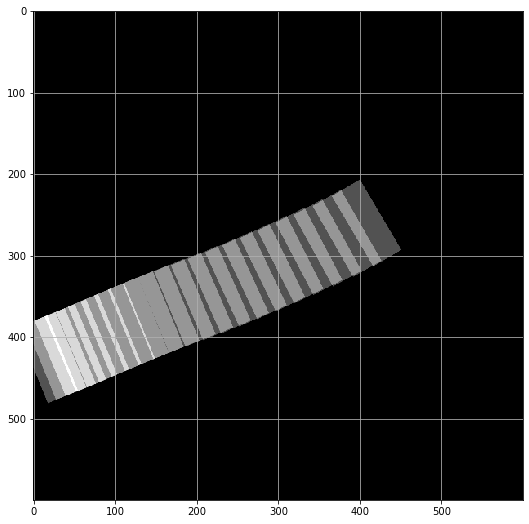

In [10]:
for f in frames[::5]:
    mosaic.add(f)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
ax.imshow(mosaic.im, cmap='Greys_r', interpolation='nearest')
ax.grid()

In [11]:
m_per_px = 0.1
width_m = 10
height_m = 25

width_px = int(width_m / m_per_px)
height_px = int(height_m / m_per_px)

K = np.array([[transform_GM.p[2] / m_per_px, 0.0,                          width_px / 2.0],
              [0.0,                          transform_GM.p[2] / m_per_px, height_px / 2.0],
              [0.0,                          0.0,                          1.0]])

# At each frame, project corners from ROI into some world mosaic frame.
frames = []
for i, d in df.iterrows():
    im = cv2.imread(d.image_00)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Transform between IMU (I) and ENU (N) frame.
    transform_NI = geometry.SE3(R=geometry.rot_from_rph_rad(d.roll, d.pitch, d.yaw),
                                p=np.array([d.pe, d.pn, d.pu]))
    
    # Let's define some ground frame (G) as a frame that is locally-level, yaw aligned with the IMU,
    # and has origin a fixed distance in front of the IMU on the ground.
    transform_GI = geometry.SE3(R=geometry.rot_from_rph_rad(d.roll, d.pitch, 0.0),
                                p=-np.array([25.0, 0.0, d.pu - 1.0]))
 
    # XXX
    frames.append(
        GroundProjection.create_test(
            transform_NG=transform_NI @ transform_GI.inverse(),
            width_m=width_m, height_m=height_m, m_per_px=m_per_px))
    
    transform_GM = geometry.SE3(R=np.array([[-1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, -1.0]]),
                                p=np.array([0.0, 0.0, 1.0]))
    
    transform_GC = transform_GI @ transform_VI.inverse() @ transform_CV.inverse()
    transform_MC = transform_GM.inverse() @ transform_GC

    R_CG = transform_GC.inverse().R
    unit_Gz_G = np.array([0.0, 0.0, 1.0])
    unit_Gz_C = R_CG @ unit_Gz_G
    dz = unit_Gz_C.dot(R_CG @ transform_GC.p)
    
    H = K @ (transform_MC.R - np.outer(transform_MC.p, unit_Gz_C) / dz) @ \
        np.linalg.inv(calibration.P_rect_00[:3, :3])
    H /= H[2, 2]
    frames[-1].im = cv2.warpPerspective(im, H, dsize=(width_px, height_px))

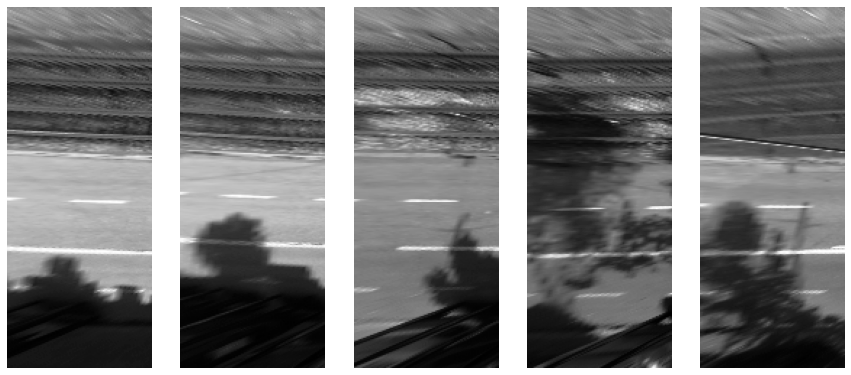

In [12]:
fig = plt.figure(figsize=(15, 9))

def _show(ax, im):
    ax.imshow(im, cmap='Greys_r')
    ax.axis('off')
    
_show(fig.add_subplot(151), frames[0].im)
_show(fig.add_subplot(152), frames[int(0.2 * len(frames))].im)
_show(fig.add_subplot(153), frames[int(0.4 * len(frames))].im)
_show(fig.add_subplot(154), frames[int(0.6 * len(frames))].im)
_show(fig.add_subplot(155), frames[-1].im)

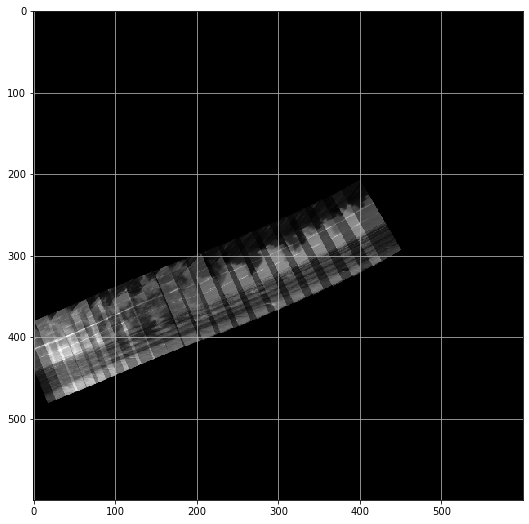

In [13]:
p_NI_N = np.vstack([df['pe'], df['pn'], df['pu']])
mosaic = GroundProjection.create(
    transform_NG=geometry.SE3(R=np.eye(3), p=np.min(p_NI_N, axis=1) + 0.5 * np.ptp(p_NI_N, axis=1)),
    width_m=150, height_m=150, m_per_px=0.25)

for f in frames[::5]:
    mosaic.add(f)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
ax.imshow(mosaic.im, cmap='Greys_r', interpolation='nearest')
ax.grid()

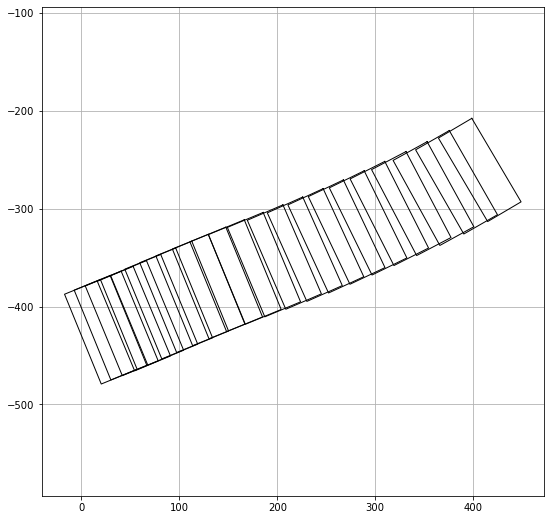

In [14]:
# Parameters for image area.
width_m = 150
height_m = 150
depth_m = 100

m_per_px = 0.25

f = depth_m / m_per_px
w = int(width_m / m_per_px)
h = int(height_m / m_per_px)

K = np.array([[f,   0.0, w / 2.0],
              [0.0,   f, h / 2.0],
              [0.0, 0.0, 1.0]])

# Construct transform between our virtual camera and the ENU frame.
p_NI_N = np.vstack([df['pe'], df['pn'], df['pu']])
transform_NM = geometry.SE3(R=geometry.rot_from_rph_deg(180.0, 0.0, 0.0),
                            p=np.min(p_NI_N, axis=1) +
                                0.5 * np.ptp(p_NI_N, axis=1) + np.array([0.0, 0.0, depth_m]))
transform_MN = transform_NM.inverse()

# At each frame, project corners from ROI into some world mosaic frame.
corners = []
for i, d in df.iterrows():
    # Transform between IMU (I) and ENU (N) frame.
    # XXX comment
    transform_NI = geometry.SE3(R=geometry.rot_from_rph_rad(d.roll, d.pitch, d.yaw),
                                p=np.array([d.pe, d.pn, d.pu]))
    
    # Let's define some local mosaic frame as a frame that is locally-level, yaw aligned with the IMU,
    # and has origin a fixed distance in front of the IMU on the ground.
    # XXX comment
    transform_GI = geometry.SE3(R=geometry.rot_from_rph_rad(d.roll, d.pitch, 0.0),
                                p=-np.array([25.0, 0.0, d.pu - 1.0]))  # p_GI_G = -(p_IG_G)
    
    # XXX
    transform_NG = transform_NI @ transform_GI.inverse()
    pts_Mi_M = [transform_MN * (transform_NG * p_Gi_G) for p_Gi_G in pts_Gi_G]
    
    def _project(p):
        uvw = K @ p
        return uvw[:2] / uvw[2]
    pts_Mi_M2d = [_project(p_Mi_M) for p_Mi_M in pts_Mi_M]
    corners.append(np.array(pts_Mi_M2d + [pts_Mi_M2d[0]]))

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
for c in corners[::5]:
    ax.plot(c[:, 0], -c[:, 1], 'k-', lw=1)  # XXX -y axis
ax.axis('equal')
ax.grid()